# Search for Patterns in Accelerometer Data

<br>

<br>

Les premières visualisations des données d'accélérométrie permettent d'identifier des différences entre signaux, en terme  d'amplitude et de fréquence. Pour aller plus loin dans l'analyse de ces différences, ou patterns, une exploration est menée à partir de méthodes d'apprentissage machine non-supervisée. En sortie d'algorithmes non-supervisés, les mouvements se regroupant en cluster permettront d'identifier des caractéristiques propres des mouvements, ainsi que leur activité associée.

La recherche de patterns est effectuée à partir des données featurisées. Chaque échantillon de ce jeu de données correspond à une fenêtre de 4 s sans chevauchement. Chaque fenêtre contient une information temporelle de l'amplitude et fréquentielle du signal d'accélération dans les quatre directions r, x, y et z. Chaque échantillon est associé à une activité humaine unique. Les données brutes proviennent de la base de donnée publique [Dataset for ADL Recognition with Wrist-worn Accelerometer Data Set](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).

La recherche de pattern peut se diviser en deux grandes étapes :
1. la réduction dimensionnelle du jeu de donénes featurisé,
2. le clustering des données réduites.

Ces deux étapes sont effectuées à partir des algorithmes u-map et HDBSCAN respectivement. Plus généralement, les outils Pandas et Numpy sont utilisés pour manipuler les données, Scikit-learn pour standardiser les données, et Matplotlib et Plotly pour visualiser les données.

<br>

<br>

In [42]:
import pandas as pd
import numpy as np

import math
import umap
import hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio



## Data Loading

Pour réaliser la recherche de patterns, on charge les données d'accélérometre prétraitées, ou featurisées. 
La featurisation permet d'extraire des variables utiles pour distinguer les ADL. Les features sont calculées pour une fenêtre de temps de 4 secondes, ou échantillon. 

Pour chaque échantillon (ligne du jeu de données), l'information sur la distribution de l'amplitude du signal et le spectre en fréquence est enregistrée selon les directions (r, x, y, z). 
- distribution en amplitude : décrite par les variables de type `X_i`, où X représente une direction r, x, y ou z, et i un des 10 bins dans cette même direction; décrite également par les variables `Xs_i`, où i représente une des statistiques suivantes : moyenne, médiane, déviation standard, les pourcentiles 5% et 95%, la skwness; soit au total 4 x 10 + 4 x 6 = 64 variables,
- spectre en fréquence : décrit par les variables de type `Xf_i`, où X représente une direction r, x, y, ou z, et i une fréquence de 0 à 12.5 Hz, par pas de 0.25 Hz; soit un total de 4 x 50 = 200 vaiables.


Le jeu de données contient également le label de l'activité effectuée (`label`), le numéro de l'échantillon d'origine (`sample`) et son ordre en temps (`time`) dans l'échantillon.
Une partie du jeu de données est affichée sur la table ci-dessous.

In [37]:
#import featurized data
df = pd.read_csv('mydata/data_featurized_bigsize_nolast_nomirror.csv', index_col=0)


# reset the index
df = df.reset_index().rename(columns={'index' : 'time'})
df.shape

(3090, 267)

In [3]:
df.head()

,time,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,...,zf_42,zf_43,zf_44,zf_45,zf_46,zf_47,zf_48,zf_49,label,sample
0,0,22.0,19.0,6.0,8.0,10.0,6.0,3.0,2.0,10.0,...,0.361153,0.027847,0.151950,0.256402,0.133421,0.486690,0.100896,0.042081,Walk,100
1,1,35.0,14.0,3.0,3.0,4.0,2.0,3.0,2.0,17.0,...,0.275081,0.316771,0.214397,0.276424,0.330371,0.399389,0.267958,0.137013,Walk,100
2,2,37.0,5.0,8.0,3.0,1.0,2.0,2.0,8.0,14.0,...,0.380161,0.481816,0.440438,0.229849,0.433399,0.249934,0.274554,0.309274,Walk,100
3,3,35.0,12.0,5.0,4.0,5.0,5.0,2.0,3.0,10.0,...,0.117861,0.361960,0.403638,0.097512,0.288698,0.256176,0.168013,0.298178,Walk,100
4,4,32.0,9.0,5.0,4.0,5.0,3.0,1.0,7.0,15.0,...,0.176033,0.186865,0.076570,0.086144,0.103892,0.253449,0.278782,0.271946,Walk,100


*Five first row of the feature dataframe.*

## Data Preparation

Avant d'effectuer l'étape clustering des échantillons, on réalise une réduction dimensionnelle avec l'algorithme u-map. Cette préparation des données permet de simplifier le problème en réduisant la dimension de l'échantillon initial à deux dimensions. Les données sont normalisées avec le StandardScaler de Scikit-Learn, puis réduite avec l'algorithme u-map, pour lequel on a réglé l'hyperparamètre `min_dist` à 0. La liste des hyperparamètres de l'algorithme est affichée ci-dessous.

In [4]:
# remove labels
X = df.drop(['label', 'sample', 'time'], axis = 1)

# normalize data
X_scl = StandardScaler().fit_transform(X)

# initialize an u-map reducer
reducer = umap.UMAP(random_state=44, min_dist=0.)

# reduce feature space into a 2D space
emb = reducer.fit_transform(X_scl)
df_emb = pd.DataFrame(emb)

print("shape of reduced feature dataframe : {}".format(df_emb.shape))

shape of reduced feature dataframe : (3090, 2)


*Data are normalized with Scikit-Learn Standard Scaler and compressed with the dimensional reduction algorithm  u-map.*

In [5]:
reducer.get_params()

{'a': None,
 'angular_rp_forest': False,
 'b': None,
 'init': 'spectral',
 'learning_rate': 1.0,
 'local_connectivity': 1.0,
 'metric': 'euclidean',
 'metric_kwds': None,
 'min_dist': 0.0,
 'n_components': 2,
 'n_epochs': None,
 'n_neighbors': 15,
 'negative_sample_rate': 5,
 'random_state': 44,
 'repulsion_strength': 1.0,
 'set_op_mix_ratio': 1.0,
 'spread': 1.0,
 'target_metric': 'categorical',
 'target_metric_kwds': None,
 'target_n_neighbors': -1,
 'target_weight': 0.5,
 'transform_queue_size': 4.0,
 'transform_seed': 42,
 'verbose': False}

*List of u-map hyperparameters.*

## Cluster Extraction : Clean Environment

Le clustering est réalisé avec l'algorithme HDBSCAN. Afin d'obtenir des clusters suffisamment grands, on ajuste l'hyperamètre `min_cluster_size` à 92, ce qui correspond à des clusters supérieurs à 3 % du jeu de donnés. Deux clusters sont obtenus avec l'algorithme HDBSCAN. Le cluster majoritaire, qui regroupe 95 % des échantillons, est clairement séparé du cluster minoritaire (voir figure ci-dessous). Ce dernier cluster est nommé *6 Hz* car il est formé, comme nous le verrons par la suite, d'une forte proportion d'échantillons de fréquence autour de 6 Hz.

Pour aller plus loin dans l'interprétation des échantillons, on réalise dans la sous-partie suivante une nouvelle étape de clustering en retirant les échantillons du cluster 6 Hz.

In [40]:
thresh_3perc

92

In [6]:
# set a threshold for the size of HDBSCAN clusters
# at 3 % of the  total sample size
thresh_3perc = int(3 * len(df) / 100)

# instantiate a HDBSCAN algo for clustering
clusterer1 = hdbscan.HDBSCAN(min_cluster_size= thresh_3perc)

# train HDBSCAN
clusterer1.fit(emb)

HDBSCAN(min_cluster_size=92)

*Perform clustering with HDBSCAN.*

In [7]:
# numpy to pandas conversion
df_emb = pd.DataFrame(emb)

# rename u-map components
df_emb = df_emb.rename(columns={0 : 'x_umap', 1 : 'y_umap'})

# add cluster label to each row
df_emb['cluster'] = clusterer1.labels_.astype(str)

# rename HDBSCAN clusters
cluster_order = df_emb["cluster"].value_counts().index
df_emb = df_emb.replace(cluster_order, ["Main", "6 Hz"])

*Create a new dataframe with u-map components and HDBSCAN clusters.*

In [8]:
# colors for HDBSCAN clusters
colorLab1 = plt.cm.get_cmap('Accent')
colorLab1 = list(colorLab1.colors)

# HDBSCAN cluster column
clusti = df_emb['cluster']

# assign a color to each HDBSCAN cluster
clust1_colormap = {}
for i, j in zip(clusti.unique(), colorLab1[:clusti.nunique()]):
    clust1_colormap[i] = j

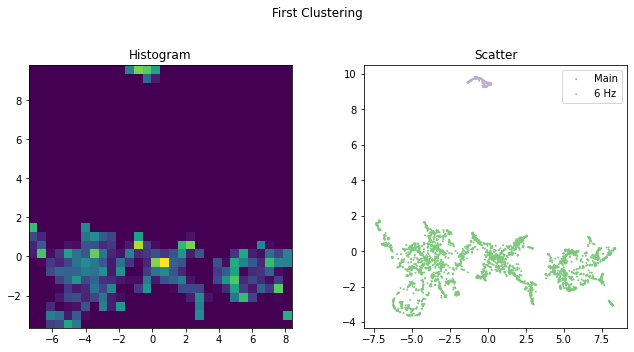

In [47]:
# need a Function here
fig1, ax = plt.subplots(1, 2, figsize=(10, 5.5))

# plot 2-D histogram of samples
# versus u-map x and y components
fig1.suptitle('First Clustering')
ax[0].hist2d(x = df_emb['x_umap'], y = df_emb['y_umap'], bins = [30,30])
ax[0].title.set_text('Histogram')

labels = df_emb['cluster'].unique()
# scatter plot of samples
# versus u-map x and y components
for i in range(len(labels)):
    data = df_emb.loc[df_emb['cluster'] == labels[i]]
    ax[1].scatter(x = data['x_umap'], y=data['y_umap'], 
                color=data['cluster'].map(clust1_colormap),
                s = 1.0,
                label=labels[i]
               )
ax[1].title.set_text('Scatter')
plt.legend()

fig1.tight_layout(pad=5.0)
plt.show()

*Sample Distribution as function of u-map x and y components, showned as a 2-D histogram (left) and as a scatter plot (right).*


## Cluster Extraction : Noisy Environment

Après avoir retirer les échantillons du cluster 6 Hz, on réalise une nouvelle étape de clustering. Comme pour la première étape, on effectue au préalable une réduction dimensionnelle avec l'algorithme u-map, de dimension deux, et de `min_dist` nul. Le clustering est à nouveau réalisé avec l'algorithme HDBSCAN avec un `min_cluster_size`de 92.

La distribution des échantillons dans le plan réduit (composantes d'u-map) permet de distinguer des zones à plus forte densités séparées par des zones de plus faible densité. La séparation des clusters étant moins évidente que pour la première étape de clustering, on va tuner les hyperparamètre d'HDBSCAN pour trouver la solution la plus adapté à nos données. On cherche a obtenir un nombre suffisamment grand de cluster tout en maintenant un niveau de bruit faible (le bruit provient des échantillons qui ne sont pas associés à un cluster par HDBSCAN). Pour trouver une solution adaptée, les hyperparamètres `min_samples` et `leaf_size` sont scannés de 1 à 81 par pas de 10.

Pour chaque jeu d'hyperamètre, on obtient un nouveau clustering. La distribution du pourcentage de bruit en fonction du nombre de clusters est affichée sur la figure ci-desous, sous la forme d'un histogramme 2-D et d'un diagramme de dispersion. On observe la tendance suivante : le nombre de clusters augmente avec le niveau de bruit. 
On choisit de sélectionner une partition en 4 clusters, qui permet d'obtenir un nombre suffisamment grand de pattern à étudier tout en conservant un niveau de bruit faible, d'environ 1 %.

In [10]:
# select samples in the bulk (largest cluster)
mask_main = df_emb['cluster'] == "Main"
X_b = X[mask_main]

# normalize data
X_b_scl = StandardScaler().fit_transform(X_b)

# initialize an u-map reducer
reducer2 = umap.UMAP(random_state=44, min_dist=0.)

# reduce feature space into a 2D space
emb_b = reducer2.fit_transform(X_b_scl)

*Samples from the 6 Hz cluster are removed. The remaining samples are normalized with Scikit-Learn Standard Scaler and reduced with u-map algorithm.*

In [11]:
def get_nnoise_nclust(hdb_labels):
    '''
    from a list a cluster labels, return
    - the number of noise point (label = "-1")
    - the number of non noise clusters
    '''

    # samples labeled as noise by HDBScan
    mask_noise = hdb_labels == "-1"
    
    # number of sample labeled as noise
    n_noise = mask_noise.sum()
    
    # number of HDBSCAN cluster (non noise)
    n_clust = hdb_labels[~mask_noise].nunique()
    
    return n_noise, n_clust

In [12]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size= thresh_3perc)

# grid of HDBSCAN hyperparameter values to test
param_grid = {'min_samples': range(1, 90, 10),
              'leaf_size' : range(1, 90, 10)}

params_grid = ParameterGrid(param_grid)

list_nnoise = []
list_nclust = []


# loop over HDBSCAN hyperparameter grid
for hypset in params_grid:
    # assign new hyperparameters to HDBSCAN
    clusterer2.set_params(**hypset)
    
    # train HDBSCAN on dataset
    clusterer2.fit(emb_b)
    
    # HDBSCAN cluster labels
    hdb_labels = pd.Series(clusterer2.labels_.astype(str))
    
    # get nb of noise points and nb of clusters
    n_noise, n_clust = get_nnoise_nclust(hdb_labels)
    
    list_nnoise.append(n_noise)
    list_nclust.append(n_clust)

In [13]:
# put hyperparameter grid in a pandas table
grid_rest = pd.DataFrame(list(params_grid))

# add corresponding nb of noise and nb of clusters
grid_rest['n_noise']  = list_nnoise
grid_rest['n_clust'] = list_nclust

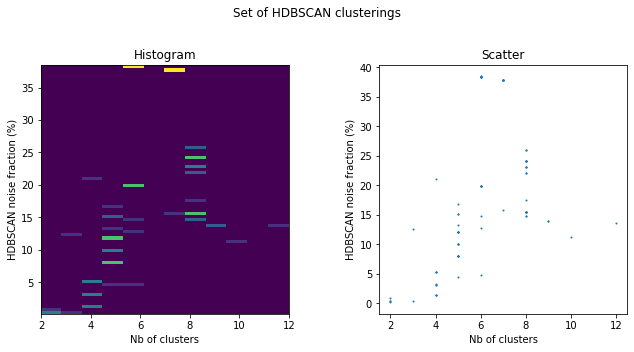

In [14]:
fig2, ax = plt.subplots(1, 2, figsize=(10, 5.5))

# plot 2-D histogram of samples
# versus u-map x and y components
fig2.suptitle('Set of HDBSCAN clusterings')

# compute noise cluster size in percentage
noise_percent = [i * 100 / len(emb_b) for i in list_nnoise]

ax[0].hist2d(x = grid_rest['n_clust'],
             y = noise_percent,
             bins = [grid_rest['n_clust'].max(),80])
ax[0].title.set_text('Histogram')

ax[1].scatter(x = grid_rest['n_clust'], y=noise_percent, 
              s = 1.0)
ax[1].title.set_text('Scatter')


for i in ax.flat:
    i.set(xlabel='Nb of clusters', ylabel="HDBSCAN noise fraction (%)")

fig2.tight_layout(pad=5.0)
plt.show()

*Diagramme de dispersion des clustering d'HDBSCAN en fonction du nombre de points de bruits par clustering (y) et du nombre de clusters obtenus (x).*

### Interprétation Statistique

Le diagramme de dispersion des échantillons (sans le cluster 6 Hz) dans le plan réduit d'u-map (ci-dessous) permet de visualiser la séparation obtenue avec l'algorithme HDBSCAN. Cette séparation capture des patterns dans les données, c'est-à-dire des zones de plus forte densités. Les noms des clusters prendront sens lors de l'analyse de leurs caractéristiques physiques.

Le diagramme circulaire ci-dessous permet de visualiser la taille relative, en nombre d'échantillons, des clusters d'HDBSCAN pour l'ensemble des échantillons. On peut classer les clusters en 3 tailles :
- grande taille (~ 60 %) : cluster Broad 1.8 Hz
- taille moyenne (~ 25 %) : cluster Sharp 1.8 Hz
- petite taille (~5 %) : clusters High z Amp, High x Amp et 6 Hz

Le cluster Broad 1.8 Hz, bien qu'étant de grande taille, montre des signes de division. Aux frontières du cluster apparaissent des zones plus denses qui se dégagent, formant des proto-clusters. L'extraction de nouvelles informations à partir des mesures accélérométriques permettrait sans doute de segmenter ce cluster de grande taille en clusters aux caractéristiques propres.

In [15]:
# select segmentation with at list 4 clusters
mask = grid_rest['n_clust'] == 4

grid_rest_sel = grid_rest[mask]

# get the set of HDBSCAN hyperparameter values 
# that minimize the nb of noise points
best_hdb_hyp = grid_rest_sel.sort_values(by="n_noise").iloc[0][param_grid.keys()].to_dict()


# fit HDBSCAN on data with best hyperparameters
clusterer2.set_params(**best_hdb_hyp)
clusterer2.fit(emb_b)

HDBSCAN(leaf_size=11, min_cluster_size=92, min_samples=21)

*Samples are clustered with the 'best' HDBSCAN, i.e the one with hyperparameters set to get 4 non-noise clusters and minimize the noise.*

In [16]:
# numpy to pandas conversion
df_emb_b = pd.DataFrame(emb_b)

# rename u-map components
df_emb_b = df_emb_b.rename(columns={0 : 'x_umap', 1 : 'y_umap'})

# add cluster label to each row
df_emb_b['cluster'] = clusterer2.labels_.astype(str)

# retrieve sample indices
df_emb_b.index = X_b.index

In [17]:
# rename cluster labels
# with physcial meaning
cluster_naming = {
                  "0"  : "Sharp 1.8 Hz",
                  "3"  : "Broad 1.8 Hz",
                  "2"  : "High x Amp",
                  "1"  : "High z Amp",
                  "-1" : "Noise"
                 }

df_emb_b = df_emb_b.replace(cluster_naming.keys(), cluster_naming.values())

*HBBSCAN clusters are renamed according to their main physical property.*

In [18]:
# HDBSCAN cluster column
clusti = df_emb_b['cluster']

del colorLab1[3]

# assign a color to each HDBSCAN cluster
clust2_colormap = {}
for i, j in zip(clusti.unique(), colorLab1[2:clusti.nunique() + 2]):
    clust2_colormap[i] = j

*Each HDBSCAN cluster is assigned to a unique color.*

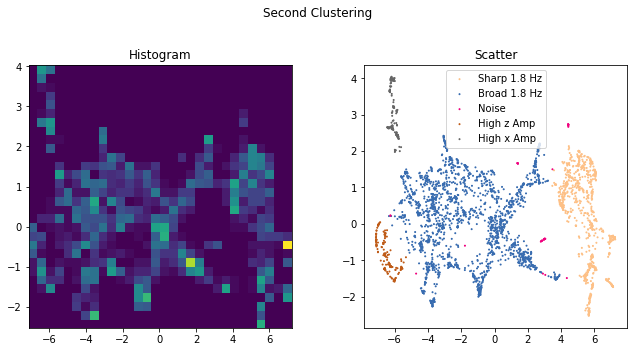

In [48]:
# need a Function here
fig3, ax = plt.subplots(1, 2, figsize=(10, 5.5))

# plot 2-D histogram of samples
# versus u-map x and y components
fig3.suptitle('Second Clustering')
ax[0].hist2d(x = df_emb_b['x_umap'], y = df_emb_b['y_umap'], bins = [30,30])
ax[0].title.set_text('Histogram')

labels = df_emb_b['cluster'].unique()
# scatter plot of samples
# versus u-map x and y components
for i in range(len(labels)):
    data = df_emb_b.loc[df_emb_b['cluster'] == labels[i]]
    ax[1].scatter(x = data['x_umap'], y=data['y_umap'], 
                color=data['cluster'].map(clust2_colormap),
                s = 1.0,
                label=labels[i]
               )
ax[1].title.set_text('Scatter')
plt.legend()


fig3.tight_layout(pad=5.0)
plt.show()

*Sample Distribution as function of u-map x and y componants, showned as a 2-D histogram (left) and as a scatter plot (right). Samples from the 6 Hz cluster have been removed before computing the clustering.*

In [20]:
# copy original dataset and add clusters
df_c = df.copy()

df_c['HDBSCAN_1'] = df_emb['cluster']
df_c = df_c.replace("Main", "")

# add the cluster labels to the main dataset
df_c['HDBSCAN_2'] = df_emb_b['cluster']
df_c['HDBSCAN_2'].fillna("" , inplace=True)

df_c['HDBSCAN']= df_c['HDBSCAN_1'] + df_c['HDBSCAN_2']

*Summarize cluster informations : assign a HDBSCAN cluster to each sample.*

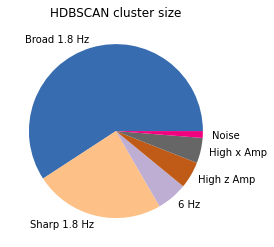

In [21]:
# histogram of HDBSCAN clusters 
histo = df_c['HDBSCAN'].value_counts()

# list of clusters colors in proper order
clustx_colormap = clust2_colormap.copy()
clustx_colormap['6 Hz'] = clust1_colormap['6 Hz']
color_list = list(histo.index.map(clustx_colormap))

# color for all HDBSCAN clusters
clustx_colormap = clust2_colormap.copy()
clustx_colormap['6 Hz'] = clust1_colormap['6 Hz']

# HDBSCAN cluster relative sizes 
fig4, ax = plt.subplots()
histo.plot.pie( x = "HDBSCAN", 
               colors= color_list, ax=ax, 
               title = "HDBSCAN cluster size"
               )
ax.get_yaxis().set_visible(False)
plt.show()

*Relative HDBSCAN cluster size (number of samples).*


## Cluster Analysis

### 1. Physical Properties

Les clusters HDBSCAN sont analysés à partir des variables de l'échantillon prétraité, ou featurisé. Pour chaque cluster, le spectre et la distribution en amplitude selon les directions r, x, y, z sont présentées dans la figure ci-dessous. À partir de ces huit plots, on peut en déduire pour chaque cluster les propriétés physiques suivantes :
- 6 Hz : un signal periodic isotrop autour de 6 Hz, haute amplitude en y
- Sharp 1.8 Hz : un signal periodic autour d'un pic à  1.8 Hz
- Broad 1.8 Hz : un signal periodic étalé autour de 1.8 Hz
- High z Amp : faiblement periodic haute amplitude selon z
- High x Amp : faiblement periodic haute amplitude selon z

Il est intéressant de noter que les clusters se démarquent à partir de certaines propriétées que l'on pourrait regrouper en deux catégories :
- les signaux fortement périodiques : comme les clusters 6 Hz et Sharp 1.8 Hz,
- les signaux fortement anisotropiques : comme les clusters High z Amp et High x Amp.

In [22]:
# remove noise sample for cluster analysis
mask_noise = df_c['HDBSCAN'] == 'Noise'
df_c = df_c[~mask_noise]

In [23]:
# size of the sample windows for 
# feature computation
window_size = 100

# sampling frequency of the instrumentation
samplingfrequency = 25

# mapping : (fft array index) -> frequency
f = np.fft.fftfreq(window_size)*samplingfrequency

# compute the mean of all features per cluster
df_mean = df_c.groupby('HDBSCAN').mean()
df_mean

freqR = df_mean.filter(like='rf_').T
freqR['freq'] = f[:int(window_size / 2)]

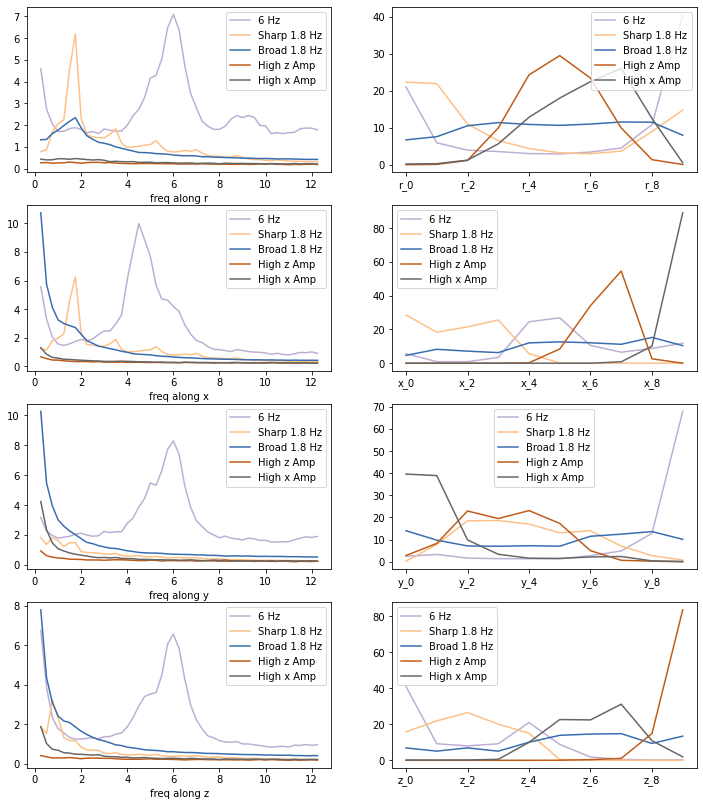

In [24]:
# list of spatial direction features
features = ['r', 'x', 'y', 'z']

fig5, axs = plt.subplots(4, 2, figsize=(12, 14))
count = 0

# loop over (r, x, y, z) axis
for elt in features:

    # plot spectrum 
    df_tmp_f = df_mean.filter(like= elt + 'f_').T
    xlabel_f = 'freq along ' + elt
    
    # filter features computed along the direction 'elt' = (r, x, y, z)
    df_tmp_f[xlabel_f] = f[:int(window_size / 2)]
    df_tmp_ = df_mean.filter(like= elt + '_').T

    
    ## loop over HDBSCAN clusters
    #for key in clustx_colormap:
    #    print(key)
    #    df_tmp_f[xlabel_f] = f[:int(window_size / 2)]
    #    df_tmp_ = df_mean.filter(like= elt + '_').T
    #    # plot spectrum
    #    df_tmp_f[1:].plot(y= keys,     c= clustx_colormap[key] , x=xlabel_f,   ax=axs[count,0])
    #    
    #    # plot amp distribution
    #    df_tmp_.plot(y= keys,          c=clustx_colormap[keys],         ax=axs[count,1])
        
    df_tmp_f[1:].plot(y= "6 Hz",        c=clustx_colormap["6 Hz"],         x=xlabel_f,   ax=axs[count,0])
    df_tmp_f[1:].plot(y= "Sharp 1.8 Hz",c=clustx_colormap["Sharp 1.8 Hz"], x=xlabel_f,   ax=axs[count,0])
    df_tmp_f[1:].plot(y= "Broad 1.8 Hz",c=clustx_colormap["Broad 1.8 Hz"], x=xlabel_f,   ax=axs[count,0])
    df_tmp_f[1:].plot(y= "High z Amp",  c=clustx_colormap["High z Amp"],   x=xlabel_f,   ax=axs[count,0])
    df_tmp_f[1:].plot(y= "High x Amp",  c=clustx_colormap["High x Amp"],   x=xlabel_f,   ax=axs[count,0])
#
    
    # plot amplitude distribution
    df_tmp_.plot(y= "6 Hz",          c=clustx_colormap["6 Hz"],         ax=axs[count,1])
    df_tmp_.plot(y= "Sharp 1.8 Hz",  c=clustx_colormap["Sharp 1.8 Hz"], ax=axs[count,1])
    df_tmp_.plot(y= "Broad 1.8 Hz",  c=clustx_colormap["Broad 1.8 Hz"], ax=axs[count,1])
    df_tmp_.plot(y= "High z Amp",    c=clustx_colormap["High z Amp"],   ax=axs[count,1])
    df_tmp_.plot(y= "High x Amp",    c=clustx_colormap["High x Amp"],   ax=axs[count,1])
    count = count + 1
    
plt.show()

*Spectrums (left) and amplitude distributions (rigth) computed along the spatial directions (r, x, y, z) for each HDBSCAN cluster.*

### 2. ADL Labels

La composition des clusters HDBSCAN en terme de labels ADL est donnée par les diagrammes circulaires ci-dessous. On peut observé les traits suivants : 
- 6 Hz : exclusivement composés de l'activité *brossage de dents*
- Sharp 1.8 Hz : mouvements de marche, ou liés à la marche (montée ou descente d'escalier)
- Broad 1.8 Hz : équitablement réparti en plusieurs catégories, notamment *se lever du lit*, *verser de l'eau* ou encore *boire de l'eau*
- High z Amp : constitué à plus de 75 % de l'activité *manger de la viande*
- High x Amp : constitué à environ 80 % des activités *utiliser son téléphone* et *boire un verre*

Il est intéressant de remarquer que le cluster High x Amp est constitué d'une proportion non négligeable (~ 15 %) de l'activité *se lever du lit*, alors qu'il est dominé par des activités *utiliser son téléphone* et *boire de l'eau*, mettant en jeu le mouvement du poignet. Il est possible de considérer que certains ADL labelisés *se lever du lit* correspondent à un individu se levant  de son lit juste après avoir utiliser son téléphone (pour éteindre l'alarme ou regarder ses dernières notifications). En somme, il se peut que les labels ne prennent pas en compte toute la complexité des activités, et que celle-ci pourrait être mise en lumière grâce à une analyse non-supervisée des données.

In [25]:
# assign 1 color per ADL label
colorLabels = plt.cm.get_cmap('tab20c')
colorLabels = list(colorLabels.colors)

# labels names + 'other'
labels_other =  ['Pour_water',
                 'Drink_glass',
                 'Eat_meat',
                 'Getup_bed',
                 'Walk',
                 'Climb_stairs',
                 'Descend_stairs' ,
                 'Liedown_bed',
                 'Comb_hair',
                 'Standup_chair',
                 'Sitdown_chair',
                 'Use_telephone',
                 'Brush_teeth',
                 'Eat_soup',
                 'Other']

# create a df and make the mapping :
# label -> color (for plots)
df_labelColr = pd.DataFrame(index=labels_other)
df_labelColr['color'] = colorLabels[:len(df_labelColr)]

,color
Pour_water,"(0.19215686274509805, 0.5098039215686274, 0.74..."
Drink_glass,"(0.4196078431372549, 0.6823529411764706, 0.839..."
Eat_meat,"(0.6196078431372549, 0.792156862745098, 0.8823..."
Getup_bed,"(0.7764705882352941, 0.8588235294117647, 0.937..."
Walk,"(0.9019607843137255, 0.3333333333333333, 0.050..."
Climb_stairs,"(0.9921568627450981, 0.5529411764705883, 0.235..."
Descend_stairs,"(0.9921568627450981, 0.6823529411764706, 0.419..."
Liedown_bed,"(0.9921568627450981, 0.8156862745098039, 0.635..."
Comb_hair,"(0.19215686274509805, 0.6392156862745098, 0.32..."
Standup_chair,"(0.4549019607843137, 0.7686274509803922, 0.462..."


*Each ADL label is assigned to a unique color.*

In [26]:
def keepNLabels(histo, nlabels = 7):
    '''
    take a series with counts for each index
    return the series with the first nlabels index
    the last nlabels + 1 are grouped into "Other" new index
    
    histo : pandas Series
    nlabels : int
    '''
    
    # sum the count of the last index
    other_count = histo[nlabels:].sum()
    
    # keep the first labels
    histo = histo[:nlabels]
    
    # add the count of the last indices
    histo["Other"] = other_count
    
    return histo

In [27]:
def getLabelHist(df, cluster_name, firstNlabels = 7):
    '''
    compute the histogram of ADL labels for 
    a given cluster (cluster_name)
    map a color for each label
    
    df : input dataframe
    firstNlabels : keep the n labels with highest count in the histo
    cluster_name : name of the cluster selected
    return a pd.Series
    '''
    
    # select samples of cluster cluster_name
    mask = df['HDBSCAN'] == cluster_name
    df = df[mask]
    
    # get the histo of ADL labels
    out = df['label'].value_counts()
    
    # keep only the firstNlabels labels, with highest count
    out = keepNLabels(out, firstNlabels)
    
    return out

In [28]:
def getColorList(hist, color_map):
    '''
    get  the list of colors for 
    the labels (or index) in hist
    
    hist : pd.Series
    color_map : pd.DataFrame
    
    out : pd.Series
    '''
    
    # merge horizontally the two series
    out = pd.concat([hist, color_map], axis = 1)
    
    # remove nan values from 
    # colors with no corresponding ADL label
    out = out.dropna()
    
    return out['color']

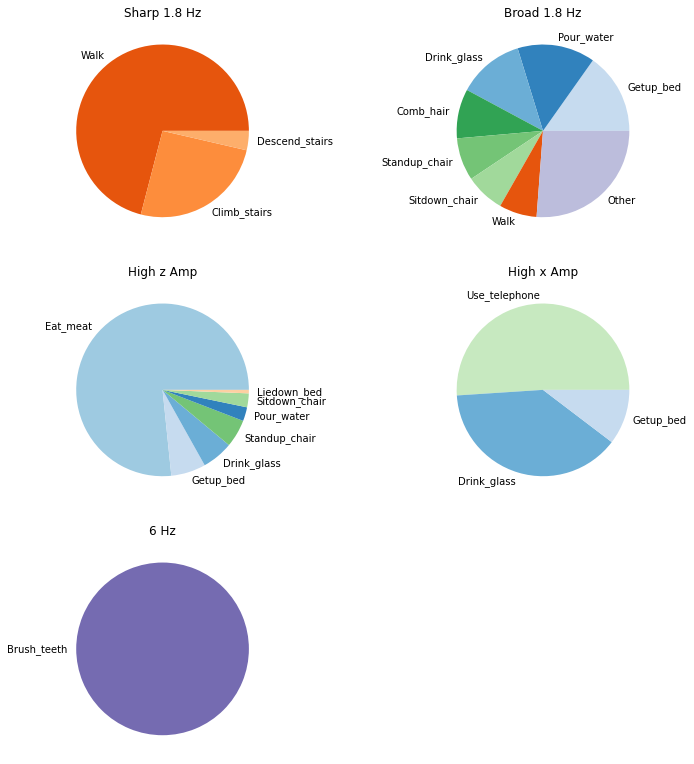

In [33]:
nrows = 3
ncols = 2
fig6, axs = plt.subplots(nrows, ncols, figsize=(12.5, 13.5))
#plt.subplots_adjust(hspace=0)

count = 0

# loop over clusters names
for elt in df_c['HDBSCAN'].unique():
    
    # move to the next subplot 
    axi = axs[math.floor(count / ncols), count % ncols]
    

    histogram = getLabelHist(df_c, elt)
    
    colors_val = getColorList(histogram, df_labelColr)
    
    histogram.plot.pie( x = "label", colors= colors_val.values, ax=axi, title = elt)
    

    # don't show y axis label
    axi.get_yaxis().set_visible(False)
    
    count = count + 1

    
fig6.delaxes(axs[2,1])
plt.show()

*ADL relative composition of the 5 HDBSCAN clusters.*

## Conclusion

Les échantillons de mesures accélérométriques, enregistrés au cours d'ADL sur une fenêtre de 4 secondes, se regoupent en clusters à partir d'informations de fréquence et d'amplitude du signal. La méthode statistique utilisée dans cette étude permet de caractériser cinq clusters de taille significative, dont quatre d'entre eux présentent des caractéristiques physiques propres et capturent des ADL spécifiques. Elle s'appuie sur un traitement en deux grandes étapes : une réduction dimensionnelle des échantillons réalisée avec l'algorithme u-map et un clustering des échantillons effectué avec l'algorithme HDBSCAN.

À partir de cette étude, nous avons pu oberser que les échantillons qui sortent du lot et se regroupent en clusters possèdent une des deux, ou les deux, caractéristiques suivante(s) : une forte périodicité, comme les mouvements à 6 ou 1.8 Hz, ou une forte anisotropie, comme les mouvements aux amplitudes élevées selon x, y ou z. Les clusters capturent également des ADL spécifiques. Les ADL 'capturés' au sein de clusters avec une pureté relativement élevée sont notamment *se brosser les dents*, *marcher*, *manger de la viande* ou encore *utiliser son téléphone*.

Enfin, le partitionnement réalisé est dominé par un cluster représentant environ 60 % des échantillons pour lequel il est difficile de dégager une caractéristique propre et un ou plusieurs ADL caractéristiques. Cependant ce cluster montre des signes prometteurs de partitionnement, avec l'apparition de zones plus denses à ses frontières. L'affinement des calculs de features permettra très certainement de partitionner ce cluster majoritaire et de découvrir de nouveaux patterns liés au mouvements des indivdus. Une piste d'amélioration consisterait à considérer d'autes directions que celles étudiées (r, x, y, z), de calculer de nouvelles statistiques à partir des spectres en fréquence, et d'extraires de nouveaux features à partir de techniques d'apprentissage profond.





## Extras

In [43]:
# plot theme
pio.templates.default = "seaborn"

In [44]:
px.scatter(x = emb_b[:, 0], y = emb_b[:, 1], color=df_emb_b['cluster'])

In [45]:
px.scatter(x = emb_b[:, 0], y = emb_b[:, 1], color=df[mask_main]['label'])